# Load Cleansed Wine Reviews

See [data preparation](wine_review-data_preparation.ipynb) for details on the prepared dataset.

Libraries

In [28]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
wine_df = pd.read_parquet('files/wine_review.parquet.gzip')
wine_df.info()
wine_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100538 entries, 0 to 129970
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   country         100538 non-null  object 
 1   description     100538 non-null  object 
 2   points          100538 non-null  int64  
 3   price           93522 non-null   float64
 4   taster_name     100538 non-null  object 
 5   title           100538 non-null  object 
 6   variety         100538 non-null  object 
 7   winery          100538 non-null  object 
 8   year            100538 non-null  int64  
 9   wine_style      100538 non-null  object 
 10  type            100538 non-null  object 
 11  quality         100538 non-null  object 
 12  classification  100538 non-null  object 
 13  location        100538 non-null  object 
 14  band            93522 non-null   object 
dtypes: float64(1), int64(2), object(12)
memory usage: 12.3+ MB


,country,description,points,price,taster_name,title,variety,winery,year,wine_style,type,quality,classification,location,band
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013,light_white,white,medium,Old World,Etna,None
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,medium_red,red,medium,Old World,Douro,popular
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,light_white,white,medium,New World,Oregon,popular
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,aromatic_white,white,medium,New World,Michigan,popular
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,light_red,red,medium,New World,Oregon,luxury


# Feature Extraction

In [30]:
import nltk

nltk.download('all');

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/patrick/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/patrick/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/patrick/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/patrick/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/patrick/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]  

In [31]:
wine_df[['description']].sample(10)

,description
19963,"A bit hard and dark at first, yet despite rubb..."
66238,This is a ripe and dense yet well-balanced win...
80869,This richly structured wine comes from the the...
72431,Here's a delicate white that's a nice poolside...
15074,This standard Chardonnay opens with blowsy mel...
81178,Fiore is a down-to-earth Sicilian wine that of...
113721,This wine's aromas are brooding and high toned...
109046,One of a range of single-vineyard wines from C...
94043,"This is easy to like for its clean, brisk mout..."
103129,"This is concentrated and ripe, with its fruit ..."


In [32]:
import wordcloud as wc

# Function for display frquency of words
def freq_words(words, title=''):
  '''
  Show frequency of words as an image
  '''
  # Generate frequency of words as an image
  freq_words_img = wc.WordCloud(background_color='white', random_state=2).generate(words)
  print(freq_words_img.words_)

  # Display the image
  plt.figure(figsize=(10, 10))
  plt.title(title)
  plt.imshow(freq_words_img)
  plt.axis("off")
  plt.show()

{'wine': 1.0, 'sweet': 0.5, 'Porty': 0.5, 'mountain': 0.5, 'grown': 0.5, 'Syrah': 0.5, 'rich': 0.5, 'cherry': 0.5, 'berry': 0.5, 'flavors': 0.5, 'smooth': 0.5, 'tannins': 0.5, 'seems': 0.5, 'residual': 0.5, 'sugar': 0.5, 'makes': 0.5, 'taste': 0.5, 'dessert': 0.5, 'table': 0.5}


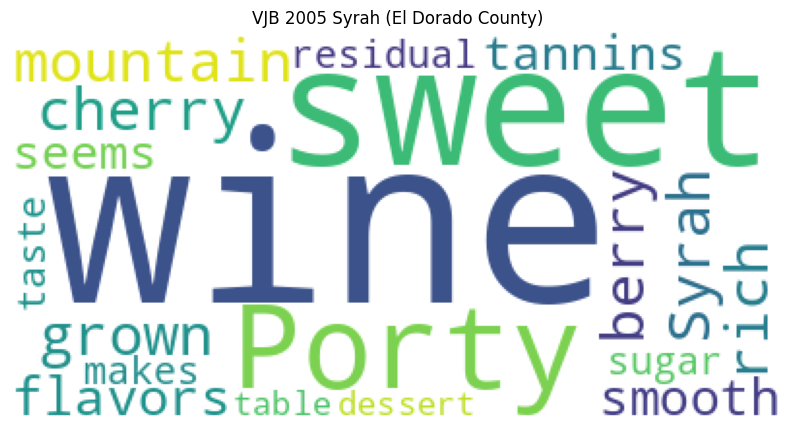

In [33]:
review = next(wine_df[['title','description']].sample(1, random_state=925).itertuples())

freq_words(review.description, review.title)

In [34]:
desc = wine_df['description']
desc.head(10)

0     Aromas include tropical fruit, broom, brimston...
1     This is ripe and fruity, a wine that is smooth...
2     Tart and snappy, the flavors of lime flesh and...
3     Pineapple rind, lemon pith and orange blossom ...
4     Much like the regular bottling from 2012, this...
7     This dry and restrained wine offers spice in p...
8     Savory dried thyme notes accent sunnier flavor...
9     This has great depth of flavor with its fresh ...
10    Soft, supple plum envelopes an oaky structure ...
11    This is a dry wine, very spicy, with a tight, ...
Name: description, dtype: object

{'sweet': 1.0, 'porty': 1.0, 'mountain': 1.0, 'grown': 1.0, 'syrah': 1.0, 'rich': 1.0, 'cherry': 1.0, 'berry': 1.0, 'smooth': 1.0, 'tannin': 1.0, 'residual': 1.0, 'sugar': 1.0, 'make': 1.0, 'dessert': 1.0, 'table': 1.0}


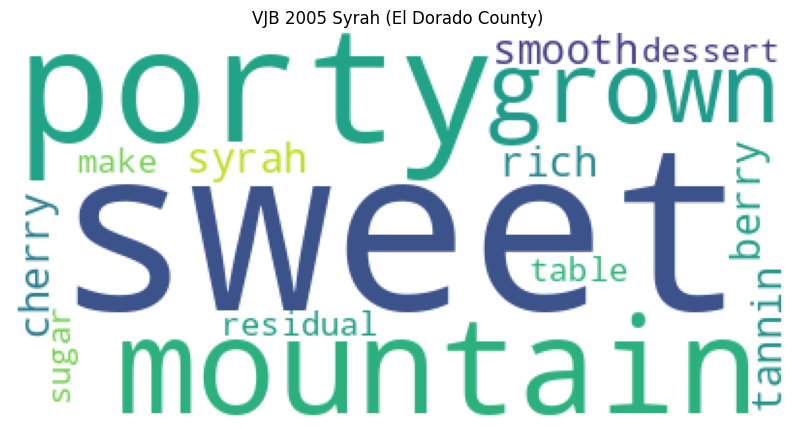

In [35]:
from utils.text_utils import remove_num_punc, remove_stop_words, lemmatize_words

review = next(wine_df[['title','description']].sample(1, random_state=925).itertuples())

desc = pd.Series(review.description)
desc = desc.apply(remove_num_punc)
desc = desc.apply(remove_stop_words)
desc = desc.apply(lemmatize_words)

freq_words(desc.values[0], review.title)

# Next
- [baseline model](wine_review-baseline_model.ipynb)